# Z2-Higgs Model Dynamics

Reproducing Fig. 17 from [arXiv:2409.03747](https://arxiv.org/abs/2409.03747).
### Hamiltonian in (1 + 1)D:

The $Z_2$-Higgs model Hamiltonian is given by:

$$
\hat{H}_{Z_2} = -g \sum_{i=1}^{L-1} \hat{X}_{i,i+1} + U \sum_{i=1}^{L} \hat{n}_i^2 
- J \sum_{i=1}^{L-1} \left( \hat{a}^\dagger_i \hat{Z}_{i,i+1} \hat{a}_{i+1} + \text{h.c.} \right)
$$

We will simulate the Trotterized dynamics for $U = 0$.

---

### Trotterized Evolution:

We evolve initial states using a first-order Trotterization:

$$
e^{-i\hat{H}_{Z_2}t} \approx \left( \hat{U}_1 \hat{U}_2 \right)^r
$$

where $\Delta t = t/r$ and:

1. **Electric field on links:**
   $$
   \hat{U}_1 = \prod_{i} e^{-ig\hat{X}_{i,i+1}\Delta t}
   $$

2. **Hopping term for bosons between sites:**
   $$
   \hat{U}_2 = \prod_{i=1}^{L-1} e^{-iJ\hat{Z}_{i,i+1}(\hat{a}^\dagger_i \hat{a}_{i+1} + \hat{a}_i \hat{a}^\dagger_{i+1})\Delta t}
   $$

---


In [ ]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
import matplotlib

We consider a $L=5$-site chain prepared in the state $|\psi_0\rangle = |00100\rangle$. The limitation to five sites is not restrictive for short timescales, as the interactions are short-range, and excitations spread with a finite velocity. As long as the “lightcone” does not reach the boundary, the results obtained are the same as in a larger system. The qubits representing the $\mathbb{Z}_2$-Higgs model gauge fields must be initialized according to Gauss’s law, ensuring consistency between the qubits and the parity in each mode. Specifically, with the leftmost gauge field qubit in $|+\rangle$ and the sites in the Fock state $|00100\rangle$, the gauge field qubits on the links between the bosonic sites are initialized in $|++--\rangle$.


In [13]:
# Parameters
numberofmodes = 5
numberofqubits = numberofmodes - 1
numberofqubitspermode = 3
cutoff = 2 ** numberofqubitspermode

# Create registers
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)  # Qumodes
qbr = qiskit.QuantumRegister(size=numberofqubits)  # Qubits for gauge fields
circuit = c2qa.CVCircuit(qmr, qbr)  # Circuit

# Initialize bosonic modes (Fock state |00100⟩)
fock_states = [0, 0, 1, 0, 0]  # Corresponds to |00100⟩
for i, fock_amplitude in enumerate(fock_states):
    coeffs = [0] * cutoff  # Initialize all coefficients to 0
    coeffs[fock_amplitude] = 1  # Set the amplitude for the desired Fock state
    circuit.cv_initialize(coeffs, qmr[i])  # Initialize each qumode

# Initialize qubits (|++--⟩)
plus_state = [1 / np.sqrt(2), 1 / np.sqrt(2)]  # Coefficients for |+⟩
minus_state = [1 / np.sqrt(2), -1 / np.sqrt(2)]  # Coefficients for |−⟩

# Apply initialization to each qubit
for i in range(numberofqubits):
    if i < 2:  # First two qubits to |+⟩
        circuit.initialize(plus_state, qbr[i])
    else:  # Last two qubits to |−⟩
        circuit.initialize(minus_state, qbr[i])

# Draw the circuit for visualization
# circuit.draw('mpl')

# state0, _, _ = c2qa.util.simulate(circuit)
# occupation0 = c2qa.util.stateread(state0, numberofqubits, numberofmodes, 2**3, verbose=False)

# print(state0)
# print(occupation0)

Now we need to define the gate sequence correspoding to a single Trotter step. Let's start with the electric field. $\hat{U}_1 = \prod_{i} e^{-ig\hat{X}_{i,i+1}\Delta t}$. This can just be implemented using a single qubit rotation.


In [14]:
def e_field(circuit, qbr, qb_index, g, delta_t):
    """
    Applies the electric field term \( \hat{U}_1 \) to a specific qubit in the gauge field qubit register.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit to modify.
        qbr (QuantumRegister): The quantum register containing the gauge field qubits.
        qb_index (int): The index of the qubit in the quantum register.
        g (float): Coupling constant for the electric field term.
        delta_t (float): Trotter time step.
    """
    theta = 2 * g * delta_t
    circuit.rx(theta, qbr[qb_index])


# e_field(circuit, qbr, 1, 1, 1)

# circuit.draw('mpl')

Now the Hopping term 2 $\hat{U}_2 = \prod_{i=1}^{L-1} e^{-iJ\hat{Z}_{i,i+1}(\hat{a}^\dagger_i \hat{a}_{i+1} + \hat{a}_i \hat{a}^\dagger_{i+1})\Delta t}$ corresponds to a conditional beam splitter.


In [15]:
def hopping_term(circuit, qbr, qb_index, qmr, mode1, mode2, j, delta_t):
    """
    Applies the hopping term \( \hat{U}_2 \) as a conditional beam splitter.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit to modify.
        qbr (QuantumRegister): The quantum register containing the gauge field qubits.
        qb_index (int): The index of the qubit in the quantum register acting as the control.
        qmr (QumodeRegister): The quantum register containing the bosonic modes.
        mode1 (int): The index of the first bosonic mode.
        mode2 (int): The index of the second bosonic mode.
        j (float): Coupling constant for the hopping term.
        delta_t (float): Trotter time step.
    """
    theta = -1j * j * delta_t
    circuit.cv_c_bs(theta, qmr[mode1], qmr[mode2], qbr[qb_index])


# hopping_term(circuit, qbr, 1, qmr, 1, 2, 1, 1)

# circuit.draw('mpl')

Now we can simulate the time evolution and get the occupation number over time.

In [ ]:
def trotter_z2_higgs(circuit, numberofmodes, numberofqubits, qmr, qbr, N, g, j, delta_t):
    """
    Trotterizes the \( \mathbb{Z}_2 \)-Higgs model over N steps.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit to modify.
        numberofmodes (int): The number of bosonic modes.
        numberofqubits (int): The number of qubits.
        qmr (QumodeRegister): The quantum register containing the bosonic modes.
        qbr (QuantumRegister): The quantum register containing the gauge field qubits.
        N (int): The number of Trotter steps.
        g (float): Coupling constant for the electric field term.
        j (float): Coupling constant for the hopping term.
        delta_t (float): Trotter time step.

    Returns:
        list: A list of occupation numbers for bosonic modes at each Trotter step.
    """
    occupations = []

    for step in range(N):
        # Apply electric field term to all qubits
        for qb_index in range(numberofqubits):
            e_field(circuit, qbr, qb_index, g, delta_t)

        for mode in range(0, numberofmodes - 1):
            hopping_term(circuit, qbr, mode, qmr, mode, mode + 1, j, delta_t)
        
        # Simulate and collect occupations
        stateop, _, _ = c2qa.util.simulate(circuit)
        occupation = c2qa.util.stateread(stateop, numberofqubits, numberofmodes, 2**3, verbose=False)
        occupations.append(np.array(list(occupation[0][0])))
        # print(f"Completed {step+1}")

    return occupations

# Example test for g/J = 0
dt = 0.1
N = 1
J = 1
g = 0
numberofmodes = 5
numberofqubits = 4
occupations = trotter_z2_higgs(circuit, numberofmodes, numberofqubits, qmr, qbr, N, g, J, dt)

Completed 1
Completed 2
Completed 3
Completed 4
Completed 5


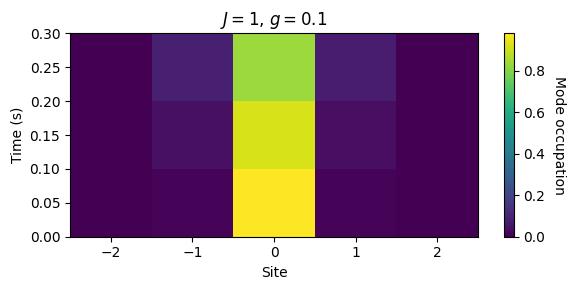

In [ ]:
# Extend occupations to match pcolormesh requirements
occupations_array = np.vstack([occupations, np.zeros((1, numberofmodes))])[:-1, :]  # Match grid dimensions

# Define x-axis (modes) and y-axis (time steps)
x_values = np.arange(numberofmodes + 1) - numberofmodes // 2 - 0.5
y_values = np.arange(N + 1) * dt * J

# Update colormap and enhance visibility with vmin and vmax
plt.pcolormesh(
    x_values,
    y_values,
    occupations_array,
    cmap='viridis',  # Use a more visually distinct colormap
    shading='auto',
    vmin=0,  # Set minimum value to the lowest occupation
    vmax=np.max(occupations_array)  # Set maximum value to the highest occupation
)
plt.title(f"$g/J = {g / J}$")
plt.xlabel("Site")
plt.ylabel("Time ($Jt$)")

# Add color bar
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label("Mode occupation", rotation=270)

# Adjust figure size and layout
plt.rcParams["figure.figsize"] = (6, 3)
plt.tight_layout()

# Save plot to PDF
plt.savefig("Z2_no_noise.pdf", format='pdf', bbox_inches='tight')

# Close the plot to avoid overlapping when creating new plots later
plt.close()
